# GSI Technology Video Search Demo - Evaluation Notebook

This notebook will perform a deep analysis of the performance of a text-to-video search application. <br>
It will perform an elaborate evaluation over two test sets and several trained models and search methods, reviewing trade-offs between accuracy and fast similarity search. <br>

## Model Architecture

To extract feature vectors from raw video data will use the **CLIP4Clip** model architecture - <br>
A CLIP-based video retrieval method, based on [this paper](https://arxiv.org/pdf/2104.08860.pdf) and [code](https://github.com/ArrowLuo/CLIP4Clip) by Luo et al, 2021.

A figure of the CLIP4Clip framework:
    

<div>
<img src="https://github.com/ArrowLuo/CLIP4Clip/blob/master/CLIP4Clip.png?raw=true" width="1000"/>
</div>

## Datasets

For the purpose of this analysis we will use:
1) The [**MSR-VTT**](https://openaccess.thecvf.com/content_cvpr_2016/papers/Xu_MSR-VTT_A_Large_CVPR_2016_paper.pdf) dataset (Xu et al., 2016):<br>
    *A dataset composed of 10,000 videos, each with a length that ranges from 10 to 32 seconds and 200,000 captions.* <br>
    MSR-VTT is a popular video benchmark used in many papers. We will use it for an initial evaluation and sanity test, by comparing acheived accuracy to the original [CLIP4Clip paper](https://arxiv.org/pdf/2104.08860.pdf). <br><br>
But the MSR-VTT test set includes only 1000 video samples. <br>
For a real-world demo, exhibiting search on a large and versatile database, we need a much larger database. <br>
To evaluate search in a large-scal database we will use: <br><br>
2) The [**Webvid-2M**](https://m-bain.github.io/webvid-dataset/) dataset (Bain et al., 2021): <br>
    *A large-scale dataset of short videos with textual descriptions sourced from stock footage sites. The videos are diverse and rich in their content.* <br>
    The majority of this dataset is originally designed for training, but to demonstrate and evaluate a large-scale search - we will use a different data split than the one defined by the [webvid team](https://arxiv.org/pdf/2104.00650.pdf), and direct ~1.5M videos for test and train on no more than 150K video samples.
    
<br>
Now let us begin:

    

## Requirements

### Environment & Dependencies

For your conveneinence we have included a dockerfile consisting of all the requirements to build and run a GPU + pytorch Nvidia image container for this project. <br>
If you haven't had experience with docker containers, there are many good tuturials available online (like [this](https://blog.roboflow.com/nvidia-docker-vscode-pytorch/) one). <br><br>

Alternatively, you can install the requirements included using `pip install -r requirements.txt` <br>
For the purposes of this demo we used **pytorch** *version 1.7.1* and a *GeForce RTX 2080* **GPU**.<br> 


## Imports

In [3]:
import random, os
import numpy as np

## MSR-VTT

We will start with the MSR-VTT test-set. <br><br>

In this evaluation notebook we will use pre-computed features for convenience.<br> 


In [7]:
DATA_PATH = './Notebooks/features'

### Evaluation:
Text-to-Video accuracy can be measured by evaluating the similarity rank of the paired video-embedding to each text-embedding within the **text-video pairs** database. <br>
In other words, we embed all the videos and their matching texts in the test set seperately, compute the similarity between each text and the entire video database, and compute recall by evaluating the rank of the matching video within the search to its paired text. <br>
e.g. recall R@10 evaluates the success rate of finding the video paired to the queried text within the 10 closest nearest neighbors from the entire database. <br> <br>
We will define the below helper fucntion that computes and prints different metrics for evaluation based on the indexes ranked by similarity:

In [5]:
def compute_metrics(nn_idx):
    y = np.eye(nn_idx.shape[0])    
    ind = np.take_along_axis(y, nn_idx, axis=1)
    ind = np.where(ind == 1)[1]
    metrics = {}
    metrics['R1'] = float(np.sum(ind == 0)) * 100 / len(ind)
    metrics['R5'] = float(np.sum(ind < 5)) * 100 / len(ind)
    metrics['R10'] = float(np.sum(ind < 10)) * 100 / len(ind)
    metrics['MR'] = np.median(ind) + 1
    metrics["MedianR"] = metrics['MR']
    metrics["MeanR"] = np.mean(ind) + 1    
    
    print('shape-similarity-matrix: {}'.format(nn_idx.shape))
    print("Text-to-Video: >>>  R@1: {:.1f} - R@5: {:.1f} - R@10: {:.1f} - Median R: {:.1f} - Mean R: {:.1f}".
        format(metrics['R1'], metrics['R5'], metrics['R10'], metrics['MR'], metrics['MeanR']))

    return metrics

For more information on computing accuracy refer to the authors [paper](https://arxiv.org/pdf/2104.08860.pdf) or [code](https://github.com/ArrowLuo/CLIP4Clip/blob/c19b819be0ef83284c05898d1596eb5acd213686/metrics.py). <br><br>
So let's verify performance on the test set: <br>
For convenience, we have precomputed and saved the embeddings for each model.

In [18]:
visual_embeddings = np.load(os.path.join(DATA_PATH, 'MSRVTT_test_visual_vectors_Cl4Cl_zeroshot.npy'))
sequence_embeddings = np.load(os.path.join(DATA_PATH, 'MSRVTT_test_textual_vectors_Cl4Cl_zeroshot.npy'))
sim_matrix = np.matmul(sequence_embeddings, visual_embeddings.transpose())
nn_idx = np.argsort(-sim_matrix, axis=1)

metrics = compute_metrics(nn_idx)


shape-similarity-matrix: (1000, 1000)
Text-to-Video: >>>  R@1: 30.9 - R@5: 54.2 - R@10: 63.3 - Median R: 4.0 - Mean R: 38.8


These results should be in sync with CLIP4Clip zero-shot, free parameter similarity Calculator, as reported by the paper for Text-to-Video search : <br>
| R@1 | R@5 | R@10 | Median R |
| --- | --- | --- | --- |
| 31.2% | 53.7% | 64.2% | 4 | 


\* Note that non-deterministic GPU behavior during embedding creation (as [reported by the authors](https://github.com/openai/CLIP/issues/114)) may lead to a variance of around ~1% from the reported accuracy.

But, of course, to achieve higher accuracy, the model sould be fine tuned on video data, as seen in the table above. <br>
For this we have trained the model on the msr-vtt training set, as done by the paper authors, using the mean-p architecture, to achieve:

In [8]:
visual_embeddings = np.load(os.path.join(DATA_PATH, 'MSRVTT_test_visual_vectors_Cl4Cl_msrvtt9k.npy'))
sequence_embeddings = np.load(os.path.join(DATA_PATH, 'MSRVTT_test_textual_vectors_Cl4Cl_msrvtt9k.npy'))
sim_matrix = np.matmul(sequence_embeddings, visual_embeddings.transpose())
nn_idx = np.argsort(-sim_matrix, axis=1)

metrics = compute_metrics(nn_idx)

shape-similarity-matrix: (1000, 1000)
Text-to-Video: >>>  R@1: 43.4 - R@5: 70.0 - R@10: 80.9 - Median R: 2.0 - Mean R: 15.7


And indeed, the results are similar to those reported in the paper:

| R@1 | R@5 | R@10 | Median R | Mean R |
| --- | --- | --- | --- | --- |
| 43.1% | 70.4% | 80.8% | 2 | 16.2 |

And as you can see, the trained model produces much higher results, with an increase of 12% - 17% in recall!


## WebVid

So for the small and poplular msr-vtt dataset, this works perfectly. But, what happens in a real-world scenario of a much larger databases?
Let us explore this case with a portion of the large webvid-2M training set.

For the purposes of the demo, we will as database the first ~1.5M video clips of the webvid training dataset. <br>
To evaluate the best model for this demo, we will test all options on the last 10K video clips from our database. <br>

So first, let's evaluate the zero shot model (each evaluation will take a few seconds here):

In [9]:
visual_embeddings = np.load(os.path.join(DATA_PATH, 'WEBVID_test10K_visual_vectors_Cl4Cl_zeroshot.npy'))
sequence_embeddings = np.load(os.path.join(DATA_PATH, 'WEBVID_test10K_textual_vectors_Cl4Cl_zeroshot.npy'))
sim_matrix = np.matmul(sequence_embeddings, visual_embeddings.transpose())
nn_idx = np.argsort(-sim_matrix, axis=1)

zs_metrics = compute_metrics(nn_idx)

shape-similarity-matrix: (10000, 10000)
Text-to-Video: >>>  R@1: 37.2 - R@5: 62.1 - R@10: 71.2 - Median R: 3.0 - Mean R: 42.2


The recall is not that great. <br>
What if we will use the model trained on the msr-vtt training set?:

In [10]:
visual_embeddings = np.load(os.path.join(DATA_PATH, 'WEBVID_test10K_visual_vectors_Cl4Cl_msrvtt_train.npy'))
sequence_embeddings = np.load(os.path.join(DATA_PATH, 'WEBVID_test10K_textual_vectors_Cl4Cl_msrvtt_train.npy'))
sim_matrix = np.matmul(sequence_embeddings, visual_embeddings.transpose())
nn_idx = np.argsort(-sim_matrix, axis=1)

msrweights_metrics = compute_metrics(nn_idx)

shape-similarity-matrix: (10000, 10000)
Text-to-Video: >>>  R@1: 38.4 - R@5: 62.9 - R@10: 72.0 - Median R: 3.0 - Mean R: 39.3


There's a *slight* improvement... <br>
But the msr-vtt trianing set is comprised of 9000 short videos cut into ~150K 12-second clips. Perhaps it is not versatile enough. <br>
What if we take a portion of the webvid dataset (a highly versatile dataset of web-scraped short clips) and direct it to training? <br>
In the next evaluation, we've trained the model on the first 150K text-video pairs from the webvid dataset, and tested on last 10K text-video pairs:


In [11]:
visual_embeddings = np.load(os.path.join(DATA_PATH, 'WEBVID_test10K_visual_vectors_Cl4Cl_webvid150k_train.npy'))
sequence_embeddings = np.load(os.path.join(DATA_PATH, 'WEBVID_test10K_textual_vectors_Cl4Cl_webvid150k_train.npy'))
sim_matrix = np.matmul(sequence_embeddings, visual_embeddings.transpose())
nn_idx = np.argsort(-sim_matrix, axis=1)

webweights_metrics = compute_metrics(nn_idx)

shape-similarity-matrix: (10000, 10000)
Text-to-Video: >>>  R@1: 50.7 - R@5: 77.3 - R@10: 85.0 - Median R: 1.0 - Mean R: 15.0


Ok... MUCH BETTER!

### Search Acceleration - Binarization
So the accuracy may be great, but performing cosine similarity calculations against 1.5M vectors consisting of 512-float32 features, for each query text, is computationally expensive for a real time application. <br>
In real world scenarios, where fast search on large databases is required, approximate search methods for fast retrieval are performed.<br>
One of these methods is to [hash](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) the features into compact binary codes, and perform a much less expensive [hamming](https://en.wikipedia.org/wiki/Hamming_distance) computation for similairty. <br><br>

We evaluated several hashing methods, including Searchium@GSI's [neural hashing](https://www.gsitechnology.com/sites/default/files/Whitepapers/GSIT-Hamming-Space-Locality-Preserving-Neural-Hashing-for-Similarity-Search.pdf), and found that interestingly, in the case of CLIP4Clip embeddings - simple binarization (by thresholding each feature at zero) is comparable to more complex methods*.

\* When maintaining a 512 bitcode length. For longer bitcodes NH should be used.

In [12]:
#binarize:
bin_visual_embeddings = np.where(visual_embeddings > 0, 1, -1).astype(np.float32)
bin_sequence_embeddings = np.where(sequence_embeddings > 0, 1, -1).astype(np.float32)

b_sim_matrix = np.matmul(bin_sequence_embeddings, bin_visual_embeddings.transpose())
b_idx = np.argsort(-b_sim_matrix, axis=1)
b_metrics = compute_metrics(b_idx)

shape-similarity-matrix: (10000, 10000)
Text-to-Video: >>>  R@1: 29.7 - R@5: 56.0 - R@10: 67.3 - Median R: 4.0 - Mean R: 49.6


Naturally, the recall deteriorates. <br> 
But we can compensate by retrieving more nearest neighbors, followed by fine tuning the ranking, using the original features and cosine similarity.
So, for example, we can extract the 100 most similar items within the binary space, using fast hamming distance on 512bit codes, and then rerank by calculating the real cosine/euclidean distance on those 100 candidates. <br>
    
Let's evluate accuracy using this method:

In [13]:
rerank = 100
cos_vals = np.take_along_axis(sim_matrix, b_idx, axis=1)
fine_tuned_idxs = np.argsort(-cos_vals[:,:rerank], axis=1)
b_idx[:,:rerank] = np.take_along_axis(b_idx, fine_tuned_idxs, axis=1)
b_rerank100_metrics = compute_metrics(b_idx)

shape-similarity-matrix: (10000, 10000)
Text-to-Video: >>>  R@1: 50.6 - R@5: 76.4 - R@10: 83.5 - Median R: 1.0 - Mean R: 43.3


We acheive comparable accuracy as exact search, using 1.5M simple hamming comparisons + only 100 cosine comparisons!*<br>

*The only value seriously compromised is the "Mean R". This is becuase far off outliers that were missed cannot be "fixed" by the fine tuning. <br>
You can play with the number of candidates to rerank from to see how it affects the Mean R:

In [14]:
rerank = 5000
cos_vals = np.take_along_axis(sim_matrix, b_idx, axis=1)
fine_tuned_idxs = np.argsort(-cos_vals[:,:rerank], axis=1)
b_idx[:,:rerank] = np.take_along_axis(b_idx, fine_tuned_idxs, axis=1)
b_rerank500_metrics = compute_metrics(b_idx)

shape-similarity-matrix: (10000, 10000)
Text-to-Video: >>>  R@1: 50.7 - R@5: 77.3 - R@10: 85.0 - Median R: 1.0 - Mean R: 17.2


To even further improve accuracy of approximate search, we can actually train the model from end-to-end to specifically optimize binary embeddings. <br>
We implemented this concept with techniques described in papers such as:
1) [HashNet: Deep Learning to Hash by Continuation](https://arxiv.org/pdf/1702.00758.pdf)
2) [TransHash: Transformer-based Hamming Hashing for Efficient Image Retrieval](https://arxiv.org/pdf/2105.01823.pdf)


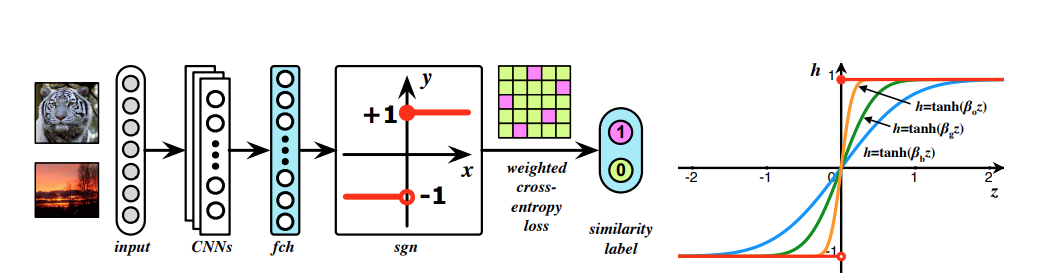

It can be seen that the binary trained model brings another ~2% improvement to the binary embeddings:

In [15]:
visual_embeddings = np.load(os.path.join(DATA_PATH, 'WEBVID_test10K_visual_vectors_Cl4Cl_webvid150k_train_binary.npy'))
sequence_embeddings = np.load(os.path.join(DATA_PATH, 'WEBVID_test10K_textual_vectors_Cl4Cl_webvid150k_train_binary.npy'))
bin_visual_embeddings = np.where(visual_embeddings > 0, 1, -1).astype(np.float32)
bin_sequence_embeddings = np.where(sequence_embeddings > 0, 1, -1).astype(np.float32)

b_sim_matrix = np.matmul(bin_sequence_embeddings, bin_visual_embeddings.transpose())
b_idx = np.argsort(-b_sim_matrix, axis=1)
bt_metrics = compute_metrics(b_idx)

shape-similarity-matrix: (10000, 10000)
Text-to-Video: >>>  R@1: 30.9 - R@5: 58.0 - R@10: 69.7 - Median R: 4.0 - Mean R: 37.7


And we will rerank again using original cosine values:

In [16]:
rerank = 100
cos_vals = np.take_along_axis(sim_matrix, b_idx, axis=1)
fine_tuned_idxs = np.argsort(-cos_vals[:,:rerank], axis=1)
b_idx[:,:rerank] = np.take_along_axis(b_idx, fine_tuned_idxs, axis=1)
bt_rerank100_metrics = compute_metrics(b_idx)

shape-similarity-matrix: (10000, 10000)
Text-to-Video: >>>  R@1: 50.8 - R@5: 76.9 - R@10: 84.3 - Median R: 1.0 - Mean R: 31.9


Lets gather all results to a conclusion table:

In [17]:
import pandas as pd
metrics = [zs_metrics,msrweights_metrics,webweights_metrics,b_metrics,b_rerank100_metrics,b_rerank500_metrics,bt_metrics,bt_rerank100_metrics]
metric_table = pd.DataFrame(metrics, index=['zero-shot model', 'msr-vtt trained', 'webvid trained', 'binary', 
                                            'binary + rerank100', 'binary + rerank500', 'binary trained', 'binary trained + rerank100'])
metric_table

R1     R5    R10   MR  MedianR    MeanR
zero-shot model             37.16  62.10  71.16  3.0      3.0  42.2128
msr-vtt trained             38.38  62.89  72.01  3.0      3.0  39.3023
webvid trained              50.74  77.30  85.05  1.0      1.0  14.9535
binary                      29.68  55.95  67.32  4.0      4.0  49.6309
binary + rerank100          50.56  76.39  83.51  1.0      1.0  43.2964
binary + rerank500          50.74  77.30  85.05  1.0      1.0  17.1879
binary trained              30.88  57.98  69.71  4.0      4.0  37.7139
binary trained + rerank100  50.75  76.88  84.31  1.0      1.0  31.9374